# Стратегия взаимодействия с пользователями в фитнес-центре

**Описание проекта**\
Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с пользователями на основе аналитических данных.
Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что пользователь больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо.
Индикаторы оттока зависят от специфики отрасли. Когда пользователь редко, но стабильно закупается в интернет-магазине — не похоже, что он «отвалился». А вот если две недели не заходит на канал с ежедневно обновляемым контентом, дела плохи: подписчик заскучал и, кажется, оставил вас.
Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и возвратившись обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.
Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество анкет пользователей.

**Задача — провести анализ и подготовить план действий по удержанию клиентов.**\
А именно:
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    - выделить целевые группы клиентов;
    - предложить меры по снижению оттока;
    - определить другие особенности взаимодействия с клиентами.

**Описание и источник данных**

«Культурист-датасаентист» предоставил сведения в csv-файлах. Заказчик подготовил набор, который содержит данные на месяц до оттока и факт оттока на определённый месяц.\
**Набор данных включает следующие поля:**\
'Churn' — факт оттока в текущем месяце;\
**Данные пользователя за предыдущий до проверки факта оттока месяц:**\
'gender' — пол\
'Near_Location' — проживание или работа в районе, где находится фитнес-центр\
'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)\
Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)\
'Phone' — наличие контактного телефона\
'Age' — возраст\
'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах)\
**Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента**\
'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)\
'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах)\
'Group_visits' — факт посещения групповых занятий\
'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента\
'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц\
'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон\
**Путь к файлу: /datasets/gym_churn.csv**

<a id="content"></a>
## Содержание
[Шаг 1. Загрузка данных](#1) \
[Шаг 2. Исследовательский анализ данных (EDA)](#2) \
[Шаг 3. Модель прогнозирования оттока пользователей](#3) 
- [3.1. Модель логистической регрессии](#31)
- [3.2. Модель случайного леса](#32)
- [3.3. Сравнение моделей](#33)

[Шаг 4. Кластеризация пользователей](#4)

**[Выводы](#summary)**

## Импорт библиотек и настройка параметров окружения

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# библиотеки для кластеризации
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [54]:
# импорт из библиотеки sklearn метрик
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [4]:
# настройка окружения
pd.options.display.max_columns=None
pd.options.display.float_format='{:.2f}'.format
sns.set(style='whitegrid')
plt.style.use('seaborn-pastel')

<a id="1"></a>
## Шаг 1. Загрузка  данных [▲](#content)

In [5]:
# загрузка исходных данных и вывод первых строк
df_gym = pd.read_csv('/datasets/gym_churn.csv')
df_gym.head().transpose()

,0,1,2,3,4
gender,1.00,0.00,0.00,0.00,1.00
Near_Location,1.00,1.00,1.00,1.00,1.00
Partner,1.00,0.00,1.00,1.00,1.00
Promo_friends,1.00,0.00,0.00,1.00,1.00
Phone,0.00,1.00,1.00,1.00,1.00
Contract_period,6.00,12.00,1.00,12.00,1.00
Group_visits,1.00,1.00,0.00,1.00,0.00
Age,29.00,31.00,28.00,33.00,26.00
Avg_additional_charges_total,14.23,113.20,129.45,62.67,198.36
Month_to_end_contract,5.00,12.00,1.00,12.00,1.00


In [6]:
# общая информация по датасету
df_gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


In [7]:
# для удобства переименовываем столбцы
df_gym = df_gym.rename(columns={
    'Near_Location':'near_loc',
    'Partner':'partner', 
    'Promo_friends':'promo', 
    'Phone':'phone',
    'Contract_period':'contract_period', 
    'Group_visits':'group_visits', 
    'Age':'age',
    'Avg_additional_charges_total':'avg_add_charges_total', 
    'Month_to_end_contract':'month_to_end', 
    'Lifetime':'lifetime',
    'Avg_class_frequency_total':'avg_class_total', 
    'Avg_class_frequency_current_month':'avg_class_curr_month',
    'Churn':'churn'      
})

**Вывод:**\
Похоже данные уже прошли хорошую предобработку: пропусков нет, текстовых данных нет.\
Никаких дополнительных действий с датасетом не требуется.

<a id="2"></a>
## Шаг 2. Исследовательский анализ данных (EDA) [▲](#content)

In [8]:
# вывод статистики по доступным столбцам
df_gym.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
gender,4000.00,0.51,0.50,0.00,0.00,1.00,1.00,1.00
near_loc,4000.00,0.85,0.36,0.00,1.00,1.00,1.00,1.00
partner,4000.00,0.49,0.50,0.00,0.00,0.00,1.00,1.00
promo,4000.00,0.31,0.46,0.00,0.00,0.00,1.00,1.00
phone,4000.00,0.90,0.30,0.00,1.00,1.00,1.00,1.00
contract_period,4000.00,4.68,4.55,1.00,1.00,1.00,6.00,12.00
group_visits,4000.00,0.41,0.49,0.00,0.00,0.00,1.00,1.00
age,4000.00,29.18,3.26,18.00,27.00,29.00,31.00,41.00
avg_add_charges_total,4000.00,146.94,96.36,0.15,68.87,136.22,210.95,552.59
month_to_end,4000.00,4.32,4.19,1.00,1.00,1.00,6.00,12.00


Среднее по столбцу 'charge' составило 0.27, и поскольку признак оттока '1' это означает, что **27% клиентов покинули клуб.**

In [9]:
# вывод средних по группам постоянный клиент/отток
churn_mark = df_gym.groupby('churn').mean().transpose()
churn_mark['ratio'] = churn_mark[0] / churn_mark[1] - 1 # отнимаем от остатка деления 1, теперь 0 - отсутствие отличий
churn_mark.style.background_gradient(subset=['ratio'], cmap=sns.light_palette('red', as_cmap=True), axis=0).format('{:.2f}')

churn,0,1,ratio
gender,0.51,0.51,-0.00
near_loc,0.87,0.77,0.14
partner,0.53,0.36,0.50
promo,0.35,0.18,0.92
phone,0.90,0.90,0.00
contract_period,5.75,1.73,2.32
group_visits,0.46,0.27,0.73
age,29.98,26.99,0.11
avg_add_charges_total,158.45,115.08,0.38
month_to_end,5.28,1.66,2.18


Наибольшие отличия: lifetime, month_to_end, contract_period, avg_class_curr_month.\
В первом приближении видны особенности характерные для тех кто уйдет:\
гораздо меньшая частота посещения (1 раз в неделю), они более молоды (средний возраст 27 против 30 лет), также они почти в два раза реже занимаются в группах, занимаются недавно - в среднем 1 месяц и имеют более короткие абонементы 1.7 мес. против 5.7. Наличие контактного телефона, близость локации на отток не влияют.


In [10]:
# наименьшее отличие в группах между ушедшими/оставшимися клиентами это факт наличия/отсутствия контактного телефона
# для исключения лишних 'шумов' при поиске значимых связей это столбец удаляем
df_gym = df_gym.drop(columns='phone')

In [11]:
# # построение матрицы корреляций (табличная форма)
# df_gym.corr().style\
#              .background_gradient(cmap=sns.light_palette('limegreen', as_cmap=True))\
#              .format('{:.2f}')

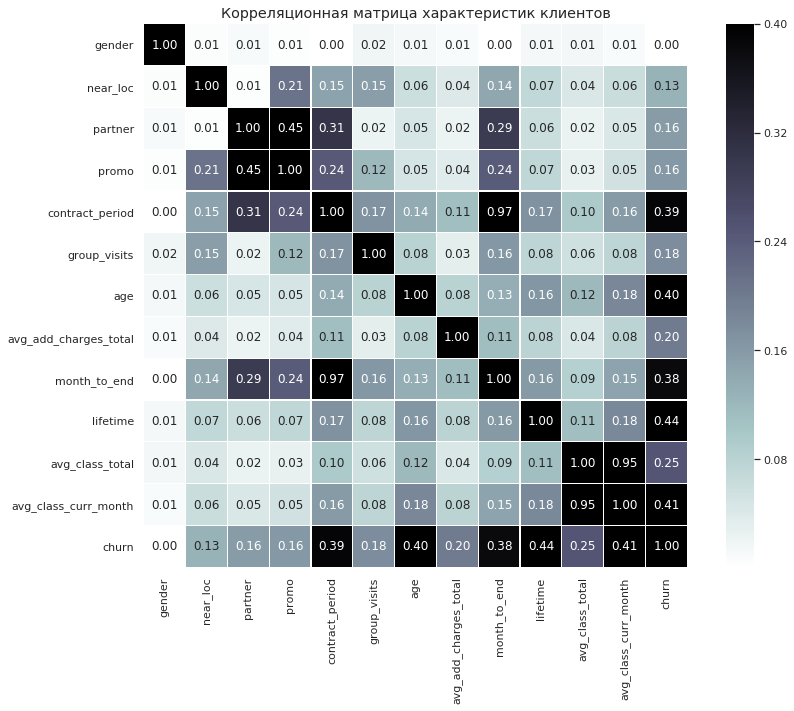

In [12]:
# Построение матрицы корреляций в формате Seaborn
# определим сперва силу влияния факторов, поэтому для удобства сравнения коэф. корреляции берем по модулю, без учета знака
plt.figure(figsize=(14,10))
g= sns.heatmap(np.abs(df_gym.corr()), # коэф. корреляции берем по модулю.
               annot=True, fmt=".2f", linewidths=.1, square=True , vmax=0.4, cmap='bone_r')
plt.title('Корреляционная матрица характеристик клиентов', fontdict={'fontsize':'large'});

**Вывод:**\
Согласно шкале Чеддока сила корреляции при значении менее 0.3 является очень слабой, поэтому выделяем только те параметры для которых коэффициент корреляции превышает это значение. Характеристики клиентов на которые стоит обратить внимание при прогнозировании оттока: 
- 'contract_period':0.39 - длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
- 'age':0.40 - возраст
- 'month_to_end':0.38 - срок до окончания текущего действующего абонемента (в месяцах)
- 'lifetime':0.44 - время с момента первого обращения в фитнес-центр (в месяцах)
- 'avg_class_curr_month':0.41 - средняя частота посещений в неделю за предыдущий месяц


Для наглядной оценки влияния отдельных параметров, строим парные диаграммы с детализацией по оттоку.

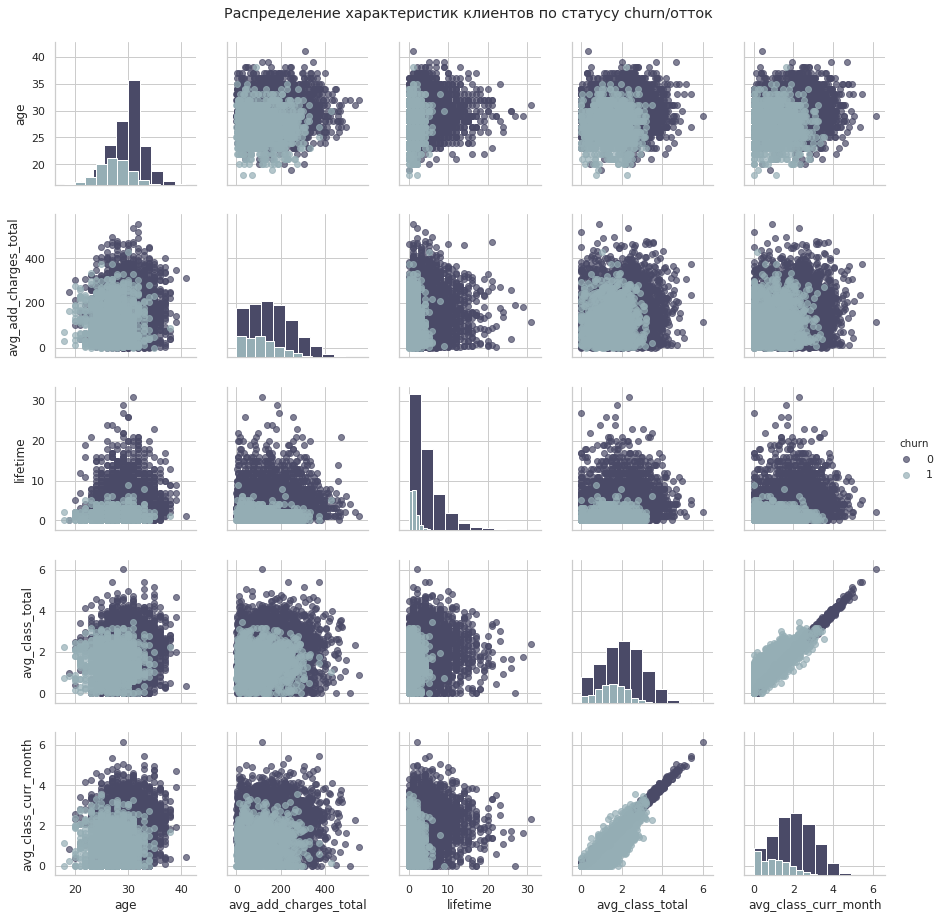

In [13]:
g = sns.PairGrid(df_gym, vars=['age', 'avg_add_charges_total', 'lifetime', 
                               'avg_class_total', 'avg_class_curr_month'],
                               hue="churn", palette="bone", despine=True)
g.map_offdiag(plt.scatter, alpha=0.7)
g.map_diag(plt.hist)
g.add_legend();
g.fig.suptitle('Распределение характеристик клиентов по статусу churn/отток', y=1.02);

**Вывод:**\
Характерные признаки групп склонных к оттоку:
- молодые люди в возрасте 25-30 лет. Возможно это связано с более частыми переменами места жительства и работы, возможно просто хотят перепробовать разные варианты.
- граница удержания по lifetime это 8 мес., те кто занимается дольше уже редко уходят.
- в среднем занимаются не более 3 раз в неделю;
- характерно резкое снижение числа тренировок в последний месяц - менее 2.

<a id="3"></a>
## Шаг 3. Модель прогнозирования оттока пользователей [▲](#content)

Постройте модель бинарной классификации пользователей, где целевой признак — факт оттока пользователя в следующем месяце:\
- Разбейте данные на обучающую и валидационную выборку функцией train_test_split(). 
- Обучите модель на train-выборке двумя способами: логистической регрессией случайным лесом 
- Оцените метрики accuracy, precision и recall для обеих моделей на валидационной выборке. 
- Сравните по ним модели. Какая модель показала себя лучше на основании метрик?

In [14]:
# выполняем разбивку выборки на обучающую и валидационную
df_train, df_valid = train_test_split(df_gym, test_size=0.25, random_state=2718)

In [15]:
# выделяем целевой столбец в выборках
features = df_train.drop(['churn'], axis=1)
target = df_train['churn'] 

features_valid = df_valid.drop(['churn'], axis=1)
target_valid = df_valid['churn']

Согласно техническому заданию нужно исследовать эффективность моделей по метрикам: accuracy, precision и recall. Для поставленной задачи - спрогнозировать отток, более ценной будет метрика **F-мера**, представляющее собой среднее гармоническое от метрик precision-recall.\
Метрика 'accuracy' является общей для всех классов (и для тех кто остался и для тех кто ушел) и в нашем случае не обладает предсказательной силой, так как изначально мы хотели определять именно тех кто ушел в 'отток'.

<a id="31"></a>
### 3.1. Модель логистической регрессии

In [46]:
# построение модели логистической регрессии
model_logistic = LogisticRegression(solver='liblinear')
model_logistic.fit(features, target)

train_logistic_predict = model_logistic.predict(features)
train_logistic_f1 = f1_score(train_logistic_predict, target)
# метрика на валидационной выборке
valid_logistic_predict = model_logistic.predict(features_valid)
valid_logistic_f1 = f1_score(valid_logistic_predict, target_valid)

print('Модель логистической регрессии')
print('Метрика F-мера на обучающей выборке: {:.3f}'.format(train_logistic_f1))
print('Метрика F-мера на валидационной выборке:{:.3f}'.format(valid_logistic_f1))

Модель логистической регрессии
Метрика F-мера на обучающей выборке: 0.863
Метрика F-мера на валидационной выборке:0.864


На валидационной выборке результат лучше чем на тренировочной. Хороший результат.

<a id="32"></a>
### 3.2 Модель случайного леса

In [59]:
# выбор модели делаем по показателю accuracy на валидационной выборке
# диапазон глубины дерева от 3 до 15 шаг 2
# диапазон числа деревьев от 10 до 20 шаг 2
result_forest = []
for max_depth in range(3, 16, 2):
    for n_estimators in range(10, 21, 2):
        model_forest = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=2718)
        model_forest.fit(features, target)
        train_forest_predict = model_forest.predict(features)
        train_forest_f1 = f1_score(train_forest_predict, target)
        valid_forest_predict = model_forest.predict(features_valid)
        valid_forest_f1 = f1_score(valid_forest_predict, target_valid)
        result_forest.append([max_depth, n_estimators, train_forest_f1, valid_forest_f1])

df_result_forest = pd.DataFrame(result_forest, columns=['max_depth', 'n_estimators', 'F_score_train', 'F_score_valid'])

print('    Модель случайного леса. Лучшие результаты')
print(df_result_forest.sort_values(by='F_score_valid', ascending=False).head())

    Модель случайного леса. Лучшие результаты
    max_depth  n_estimators  F_score_train  F_score_valid
22          9            18           0.94           0.84
20          9            14           0.94           0.84
29         11            20           0.98           0.83
23          9            20           0.95           0.83
35         13            20           1.00           0.83


**Вывод:**\
При глубине дерева больше 9 начинает возникать эффект переобучения, точность модели на тренировочных данных растет, на валидационных падает. Из двух лучших моделей по показателю F-меры выбираем модель с меньшей глубиной и числом деревьев, для ограничения эффекта переобучения:\
**max_depth=9, n_estimators=14**

<a id="33"></a>
### 3.3 Сравнение моделей

In [57]:
# предсказание по модели логистической регресии
valid_logistic_predict = model_logistic.predict(features_valid)

# предсказание по выбранной модели случайного леса    
model_forest_result = RandomForestClassifier(n_estimators=14, max_depth=9, random_state=2718)
model_forest_result.fit(features, target)
valid_forest_predict = model_forest_result.predict(features_valid)

# задаем датафрейм для результатов сравнения
df_metrics = pd.DataFrame()
df_metrics['model'] = ['Логистическая регрессия', 'Случайный лес']
# словарь с используемыми метриками
metrics = {'accuracy_score':accuracy_score, 'precision_score':precision_score, 'recall_score':recall_score,
          'f1_score':f1_score}
# расчет метрик по моделям
for metric in metrics:
    df_metrics[metric] = [metrics[metric](valid_logistic_predict, target_valid), 
                          metrics[metric](valid_forest_predict, target_valid)]

# # расчитываем усредненную метрику по моделям
# df_metrics['summary_score'] = (df_metrics['accuracy_score'] + 
#                               df_metrics['precision_score'] + df_metrics['recall_score'])/ 3           

# вывод с сортировкой по метрике Recall, лучший результат вверху
df_metrics.sort_values(by='f1_score', ascending=False)    

,model,accuracy_score,precision_score,recall_score,f1_score
0,Логистическая регрессия,0.93,0.84,0.89,0.86
1,Случайный лес,0.91,0.82,0.85,0.84


**Вывод:**\
**Лучшие результаты дает модель логистической регресии, точность предсказания оттока клиентов  89%**

<a id="4"></a>
## Шаг 4. Кластеризация пользователей [▲](#content)

In [19]:
# стандартизация данных перед работой алгоритмов кластеризации
sc = StandardScaler()
x_sc = sc.fit_transform(df_gym.drop(columns='churn')) #в аргументе убираем из датасета столбец с оттоком
linked = linkage(x_sc, method = 'ward')

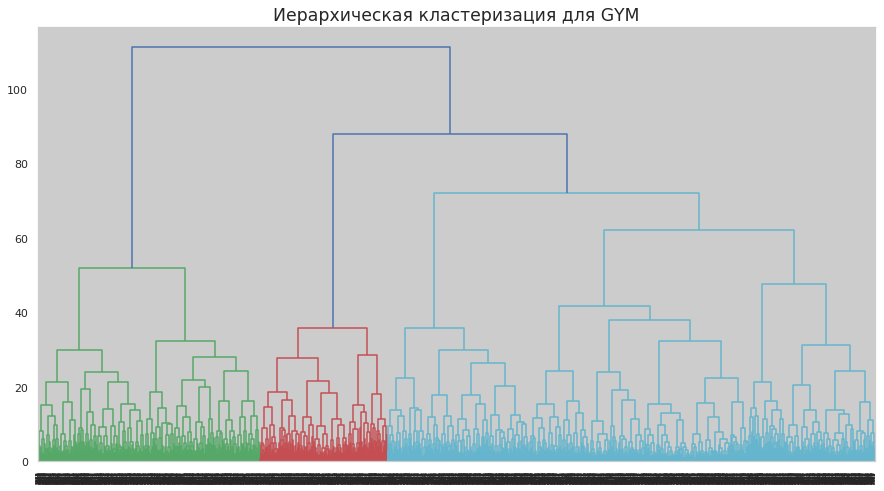

In [20]:
# построение дендрограммы
plt.figure(figsize=(15, 8))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация для GYM', fontdict={'fontsize':'x-large'})
plt.show()

**Вывод: согласно дендрограмме оптимально создание 3 кластеров** (выделение цветом)

Основная цель данного исследования - сравнить признаки наиболее "верных" клиентов и тех, кто подвержен оттоку. Поэтому основным параметром можно взять **средний 'churn' для соответствующего кластера.** Наибольший интерес будут представлять варианты кластеризации с экстремумами этого параметра, чтобы выявить наиболее значимые отличия, на которые будут направлены маркетинговые усилия. \
Число кластеров желательно установить в диапазоне от 3 до 5. Большое число групп клиентов затруднит работу с ними сотрудникам клуба, слабовыражненные отличия между группами могут внести путаницу и ошибки. В качестве примера можно привести организационную структуру в армии, где для максимальной эффективности управления число подчиненных подразделений в более крупной структуре всегда находится в диапазоне 3-5. 

In [21]:
df_churn = df_gym.loc[:,('churn', 'age')].drop(columns='age')
df_result = pd.DataFrame() # df с результатами разного числа кластеров
for n_clusters in range(7, 2, -1):
    km = KMeans(n_clusters = n_clusters, random_state=2718) # задаём число кластеров
    labels = km.fit_predict(x_sc) # применяем алгоритм к данным и формируем вектор кластеров
    # сохраняем метки кластера в поле нашего датасета
    df_churn[str(n_clusters)] = labels
    # выводим статистику по средним значениям наших признаков по кластеру
    df_result[str(n_clusters)] = (df_churn.groupby(str(n_clusters))['churn'].mean().reset_index()['churn'])    

# в итоговый датафрейм добавляем расчетную строку с максимальной дельтой
# между минимальным и максимальным оттоком в выделенных кластерах
df_result.loc['max_delta'] = df_result.apply(lambda x: x.max()-x.min(), axis=0)   

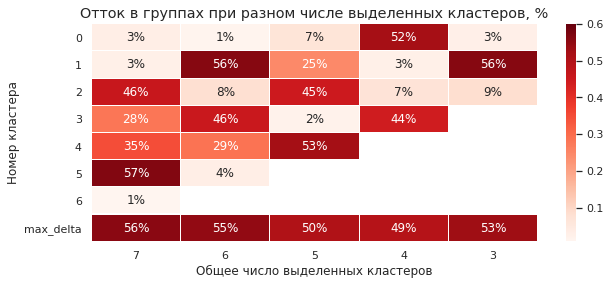

In [22]:
plt.figure(figsize=(10, 4))
g = sns.heatmap(df_result, annot=True, fmt=".0%", linewidths=.1,  vmax = 0.6, cmap='Reds');
plt.title('Отток в группах при разном числе выделенных кластеров, %', fontdict={'fontsize': 'large'});
plt.ylabel('Номер кластера');
plt.yticks(rotation='horizontal')
plt.xlabel('Общее число выделенных кластеров');

Остановимся на варианте с 6 кластерами.\
Он выглядит оптимальным по результатам анализа целевого параметра, есть группа с минимальным 1% ушедших клиентов. Всего присутствуют три группы постоянных клиентов (отток 1%, 4% и 8%), две группы "уходящих" с 46% и 57% и некая переходная группа с 29% оттока.

In [62]:
# Расчет средних параметров по выделенным кластерам
km = KMeans(n_clusters = 6, random_state=2718) # задаём число кластеров
labels = km.fit_predict(x_sc) # применяем алгоритм к данным и формируем вектор кластеров
# сохраняем метки кластера в поле нашего датасета
df_gym['cluster_km'] = labels

# выводим статистику по средним значениям наших признаков в каждом кластере
(df_gym.groupby('cluster_km').mean().transpose().sort_values(by='churn', axis=1) 
       .append(df_gym['cluster_km'].value_counts(normalize=True))
       .rename(index={'cluster_km':'customer_share'})
       .style
             .background_gradient(cmap=sns.light_palette('limegreen', as_cmap=True), axis=1)
             .background_gradient(subset={'churn'}, cmap=sns.light_palette('red', as_cmap=True), axis=1)
             .format('{:.2F}')
)             

,0,5,2,4,3,1
gender,0.47,0.54,0.60,0.48,0.50,0.48
near_loc,0.94,0.94,0.98,1.00,0.00,1.00
partner,0.77,0.74,0.18,0.79,0.46,0.23
promo,0.51,0.42,0.07,1.00,0.08,0.01
contract_period,10.60,11.32,2.15,2.80,2.04,1.79
group_visits,0.52,0.56,0.48,0.44,0.21,0.31
age,30.08,29.77,30.18,28.96,28.50,28.08
avg_add_charges_total,163.59,168.93,160.18,138.38,132.81,127.88
month_to_end,9.58,10.47,2.03,2.60,1.92,1.72
lifetime,4.78,4.76,5.08,3.48,2.76,2.19


Характерные черты групп:
- 5 'долгосрочники', 4% - клиенты на длительном контракте,  При этом группы резко отличаются по посещаемости: она довольно низкая 1.15 раза в неделю и соотвествует показателям тех кто часто уходит. Возможно их удерживает только оплаченный надолго вперед абонемент и просто нерационально бросать тренировки, а может это те кто посещает клуб по соц. пакетам от своих компаний. 
- 0 и 2 'спортсмены', отток 1% и 8% - наибольшая интенсивность занятий, почти 3 раза внеделю, но подгруппа с 8% - предпочитают короткие контракты - около 3 мес. Наболее долгожители -lifetime около 5мес.
- 3 и 1 'лентяи', отток 46% и 57% - имеют самую низкую посещаемость, около раза в неделю, также для этой группы характерно слабое участие в групповых занятиях 21-31% против 44-56% у остальных групп. 
- 3 'дальние' - у клиентов большая удаленность от клуба, возможно им просто неудобно добираться или это требует больших затрат времени. 
- 4 'группа риска', отток 29% - сниженная частота посещений 1.47 раз в неделю, по остальным параметрам близки к группам 'долгосрочников' и 'спортсменов'. Возможно это логическое развитие группы 5 по мере приближения контракта к концу.

**Вывод:**
- группы **постоянных клиентов (№0 и 2) - 34% клиентов** с оттоком 1% и 9% основное отличие во времени до конца контракта и участии в партнерских программах и промо-акциях. Вторая группа достаточно надежна, тем не менее 8% это в четрые раза больший отток. Для этой группы также характерен выбор коротких котрактов - 3 мес., при этом люди занимаются даже болле интенсивно чем в самой надежной группе - в среднем почти 3 раза в неделю против 2.
    - **Рекомендация:** похоже это истинные спортсмены, занимаются больше всех, активно участвуют во всех тренировочных процессах, пользуются доп. услугами. Нужны мероприятия для перевода их на более длительные контракты, возможно предложить какие-то индив.условия., или нужен новый формат тренировок для клиентов более высокого спортивного уровня.
-  **группа 'лентяи' - 25% клиентов**
    - **Рекомендация:** нужны мероприятия по вовлечению этих клиентов в тренировке, увеличить их частоту выше 2 раз в неделю. Возможно нужна их большая социализация, возможно у них нет знакомых или опыта занятий и они чувствуют себя неуютно. Хороший выход **вовлечение в групповые тренировки.** 98% этих клиентов оказались вне промо-акций, возможно подойдет льготная акция для перевода их на длительный контракт.
- **'группа риска' - 15% клиентов**
    - **Рекомендация:** каких либо явных отличий от постоянных клиентов по большинству критериев незаметно, явно видна более низкая посещаемость - менее 2 раз в неделю. Возможно у этих клиентов при такой низкой интенсивности занятий нет каких либо результатов по улучшению своей формы. Возможно поможет мотивационная работа, возможно групповые занятия, они проходят по определенному расписанию, возникает некая ответственность перед коллективом соревновательность и это 'притянет' большую посещаемость. 
-  **группа 'долгосрочники' - 13% клиентов**
    - **Рекомендация:** нужны мероприятия по вовлечению этих клиентов в тренировки, аналогично группе 'лентяи', возможно их удерживает от ухода только большой предоплаченный остаток по контракту.
-  **группа 'дальние' - 13% клиентов**
    - **Рекомендация:** нужны мероприятия , аналогично группе 'лентяи', возможно их удастся удержать, но предоставление особых льгот и скидок возможно не имеет смысла пока они не останутся в клубе до 4-5 мес. Они находятся далеко и высок риск их перехода в территориально более близкий к ним  клуб.    
- гендерных отличий между кластерами не выявлено. 
- возрастных отличий между кластерами не выявлено. (здесь результат отличается от выводов EDA, стоит исследовать вопрос дополнительно)
- наличие контактного телефона явно не влияет на отток, тем не менее его стоит получить хотя бы для доведения до клиентов маркетинговой информации.

<a id="summary"></a>
## Шаг 5. Выводы[▲](#content)


**1. Максимальное вовлечение клиентов в групповые занятия, особенно тех кто недавно пришел и тех кто занимается менее 2 раз в неделю.  Возможно стоит предложить несколько пробных групповых занятий бесплатно.**\
**2. Клиенты которые занимаются интенсивно (около 3 раз в неделю) и более 5 мес. предложить индивидульные условия для перевода на длительный контракт.**\
**3. Наибольший риск ухода у клиентов занимающихся менее 2 раз в неделю.**\
**4. Граничный lifitime клиентов - 8 месяцев, после этого срока клиенты почти не уходят.**

**PS**\
Вопрос о влиянии возраста остался открытым и требует дополнительного исследования. Вероятно группа клиентов 25-30 требует повышенного внимания и более склонна к оттоку.
